# Butterfly Factorization

Following the paper "[An algorithm for the rapid evaluation 
of special function transforms](https://doi.org/10.1016/j.acha.2009.08.005)", by Michael O’Neil, Franco Woolfe, Vladimir Rokhlin.

In [137]:
import numpy as np
import scipy.linalg as la
import scipy.linalg.interpolative as sli
import matplotlib.pyplot as plt
import scipy.special as sps

## Some Test Matrices

### A Matrix for the Discrete Fourier Transform

In [138]:
nlevels = 9
n = 2**(nlevels + 2)

In [139]:
omega = np.exp(2*np.pi*1j/n)

ns = np.arange(n)
exponents = ns.reshape(-1, 1) * ns

dft = 1/np.sqrt(n)*omega**exponents
idft = 1/np.sqrt(n)*omega**-exponents

In [140]:
la.norm(np.abs(idft @ dft) - np.eye(n))

5.20786734297556e-11

### Chebyshev Transform

In [141]:
k = n-1

i = np.arange(0, k+1)
x = np.linspace(-1, 1, 3000)

nodes = np.cos(i/k*np.pi)

i = np.arange(n, dtype=np.float64)
nodes = np.cos((2*(i+1)-1)/(2*n)*np.pi)
chebyshev_vdm = np.cos(i*np.arccos(nodes.reshape(-1, 1)))

In [142]:
(chebyshev_vdm.T @ chebyshev_vdm).round(2)

array([[2048.,    0.,   -0., ...,    0.,    0.,   -0.],
       [   0., 1024.,    0., ...,    0.,    0.,    0.],
       [  -0.,    0., 1024., ...,    0.,    0.,   -0.],
       ...,
       [   0.,    0.,    0., ..., 1024.,    0.,   -0.],
       [   0.,    0.,    0., ...,    0., 1024.,    0.],
       [  -0.,    0.,   -0., ...,   -0.,    0., 1024.]])

### A Random Matrix

In [143]:
randmat = np.random.randn(n, n)

## A Matrix Slicing Helper

In [144]:
class Level:
    def __init__(self, level, nlevels, n=None):
        self.level = level
        self.nlevels = nlevels
        
        if level > nlevels:
            raise ValueError("level too large")
            
        if n is None:
            n = 2**nlevels
        self.n = n
        
    @property
    def nblock_rows(self):
        return 2**self.level
        
    @property
    def block_nrows(self):
        return self.n//self.nblock_rows

    @property
    def nblock_cols(self):
        return 2**(self.nlevels-self.level)
        
    @property
    def block_ncols(self):
        return self.n//self.nblock_cols
    
    def matview(self, bi, bj, mat):
        br = self.block_nrows
        bc = self.block_ncols
        return mat[br*bi:br*(bi+1), bc*bj:bc*(bj+1)]
    
    def rowview(self, bi, vec):
        br = self.block_nrows
        return vec[br*bi:br*(bi+1)]
    
    def colview(self, bj, vec):
        bc = self.block_ncols
        return vec[bc*bj:bc*(bj+1)]

In [145]:
Level(0, nlevels, 256).matview(0, 0, dft).shape

(256, 0)

## Rank-Revealing Factorization

In [146]:
epsilon = 1e-10

In [147]:
# ID

def id_decomp(A):
    k, idx, proj = sli.interp_decomp(A, epsilon)
    sort_idx = np.argsort(idx)
    B = A[:,idx[:k]]
    P = np.hstack([np.eye(k), proj])[:,np.argsort(idx)]
    return B, P

In [148]:
# Rank-Revealing Truncated QR

def qr_decomp(A):
    q, r, p = la.qr(A, pivoting=True, mode="economic")
    diag_r = np.diag(r)
    r = r[:, np.argsort(p)]
    
    flags = np.abs(diag_r) >= epsilon
    q = q[:, flags]
    r = r[flags]
    return q, r

In [149]:
#decomp = qr_decomp
decomp = id_decomp

In [150]:
def make_low_rank_matrix(n):
    A0 = np.random.randn(n, n)
    U0, sigma0, VT0 = la.svd(A0)
    sigma = np.exp(-np.arange(n))
    return (U0 * sigma).dot(VT0)

Atest = make_low_rank_matrix(100)
Btest, Ptest = decomp(Atest)

la.norm(Atest - Btest@Ptest)/la.norm(Atest)

1.0565353581388183e-10

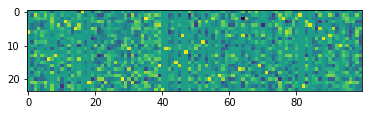

In [151]:
plt.imshow(Ptest)

## Precomputation

In [164]:
A = dft

# keys: [level][i, j]
Ps = [{} for i in range(nlevels+1)]
Bs = [{} for i in range(nlevels+1)] 

### Level 0

In [165]:
lev = Level(0, nlevels, n)

assert lev.nblock_rows == 1
for i in range(lev.nblock_rows):
    for j in range(lev.nblock_cols):
        Bs[0][i, j], Ps[0][i, j] = decomp(lev.matview(i, j, A))

### Levels 1, ..., L

In [166]:
for ilev in range(1, nlevels + 1):
    lev = Level(ilev, nlevels, n)

    for j in range(lev.nblock_rows):
        for k in range(lev.nblock_cols):
            # only process even j
            if j % 2 != 0:
                continue
                
            bblock = np.hstack((
                Bs[ilev-1][j//2, 2*k],
                Bs[ilev-1][j//2, 2*k+1],
                ))
            bblock_top = bblock[:lev.block_nrows]
            bblock_bottom = bblock[lev.block_nrows:]
            assert len(bblock_top)*2 == len(bblock)
            
            Bs[ilev][j, k], Ps[ilev][j, k] = decomp(bblock_top)
            Bs[ilev][j+1, k], Ps[ilev][j+1, k] = decomp(bblock_bottom)

            if (j, k) == (0, 0):
                print(f"Level {ilev}: {lev.block_nrows}x{lev.block_ncols}")
                pB = Bs[ilev-1][j//2, 2*k].shape
                print(f"prev level B: {pB[0]}x{pB[1]}")
                print(f"bblock (top): {bblock_top.shape[0]}x{bblock_top.shape[1]}")
                tB = Bs[ilev][j, k].shape
                tP = Ps[ilev][j, k].shape
                print(f"ID: {tB[0]}x{tB[1]} {tP[0]}x{tP[1]}")
                print()

Level 1: 1024x8
prev level B: 2048x4
bblock (top): 1024x8
ID: 1024x8 8x8

Level 2: 512x16
prev level B: 1024x8
bblock (top): 512x16
ID: 512x16 16x16

Level 3: 256x32
prev level B: 512x16
bblock (top): 256x32
ID: 256x17 17x32

Level 4: 128x64
prev level B: 256x17
bblock (top): 128x34
ID: 128x17 17x34

Level 5: 64x128
prev level B: 128x17
bblock (top): 64x34
ID: 64x17 17x34

Level 6: 32x256
prev level B: 64x17
bblock (top): 32x34
ID: 32x17 17x34

Level 7: 16x512
prev level B: 32x17
bblock (top): 16x34
ID: 16x16 16x34

Level 8: 8x1024
prev level B: 16x16
bblock (top): 8x32
ID: 8x8 8x32

Level 9: 4x2048
prev level B: 8x8
bblock (top): 4x16
ID: 4x4 4x16



Text(0, 0.5, 'Rank')

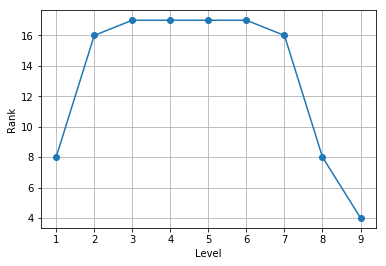

In [168]:
levels = []
ranks = []

for ilev in range(1, nlevels + 1):
    levels.append(ilev)
    ranks.append(Bs[ilev][0,0].shape[1])
    
plt.plot(levels, ranks, "o-")
plt.grid()
plt.xlabel("Level")
plt.ylabel("Rank")

Only the last-level $B$ actually needs to be retained:

In [169]:
LLB = Bs[-1]
del Bs

## Matvec

First, generate a random input:

In [170]:
x = np.random.randn(n)

### Setup

In [171]:
# keys: [ilevel][i, j]
betas = [{} for i in range(nlevels+1)]

### Level 0

In [172]:
lev = Level(0, nlevels, n)

assert lev.nblock_rows == 1
for i in range(lev.nblock_rows):
    for j in range(lev.nblock_cols):
        betas[0][i, j] = Ps[0][i, j] @ lev.colview(j, x)

### Level 1, ..., L

In [173]:
for ilev in range(1, nlevels + 1):
    lev = Level(ilev, nlevels, n)

    for j in range(lev.nblock_rows):
        for k in range(lev.nblock_cols):
            beta_glued = np.hstack((
                betas[ilev-1][j//2, 2*k],
                betas[ilev-1][j//2, 2*k+1]
                ))
            
            betas[ilev][j, k] = Ps[ilev][j, k] @ beta_glued

### Postprocess

In [174]:
Ax = np.zeros(n, dtype=np.complex128)

lev = Level(nlevels, nlevels, n)

assert lev.nblock_cols == 1
for j in range(lev.nblock_rows):
    for k in range(lev.nblock_cols):
        lev.rowview(j, Ax)[:] = LLB[j, k] @ betas[nlevels][j, k]

In [175]:
la.norm(Ax - A@x)/la.norm(A@x)

7.199035602677768e-11